In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [72]:
#设置参数
n_input = factors.shape[1] # 输入特征的个数
n_steps = 10 # LSTM模式长度为10天，每个训练样本包含过去10天的数据
n_hidden = 100 # 隐含层神经元数为每层100个
n_layers = 1 #隐藏层数为2
n_classes = 3  # 三个类别，下跌，震荡，上涨
batch_size = 100 #单个训练批次样本数为100
n_train_batch = 500 #训练多少个batch，要么设置n_train_batch，要么设置n_epochs
#n_epochs = 10 #epoch的个数：整个训练数据循环多少次
learning_rate = 0.001 #学习率为0.001
keep_prob = 0.5 #dropout 0.5
display_step = 10 #每训练多少个batch显示一次结果

In [73]:
#构造dataset
#读取数据
data = pd.read_excel('AU.xlsx')
factors = data.drop(['label'],axis = 1)
#对label进行one-hot处理
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

label = to_categorical(list(data['label'].values))

train_test_rate = 0.8 #训练与测试的比例
input_data = []
label_data = []
for i in range(factors.shape[0]-n_steps-1):
    input_data.append(factors[i:n_steps+i].values)  #每一个输入的维度为（10，20），包含过去10天信息
    label_data.append(label[n_steps-1+i])  #每一个label的维度为（1,3）
input_data = np.array(input_data)
label_data = np.array(label_data)
n_train = int(label_data.shape[0]*train_test_rate)
train_x,test_x = input_data[:n_train],input_data[n_train:]
train_y,test_y = label_data[:n_train],label_data[n_train:]

In [74]:
#构造输入输出以及batch
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
#将数据集转为tf.data.Dataset的形式方便batch和迭代
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)
train_dataset = train_dataset.repeat() #为了跑完一个epoch之后仍能正常读取数据
iterator = train_dataset.make_one_shot_iterator()
batch_dataset = iterator.get_next()

In [75]:
#创建神经网络结构：2层神经网络
def lstm_cell(): #创建一层神经网络 激活函数默认用tanh
    global n_hidden
    return tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, name='basic_lstm_cell')
def drop_out_lstm(): #添加dropout层
    global keep_prob
    return tf.contrib.rnn.DropoutWrapper(lstm_cell(), output_keep_prob = keep_prob)

multi_cells = tf.contrib.rnn.MultiRNNCell([drop_out_lstm() for i in range(n_layers)])

#动态多层
outputs,states  = tf.nn.dynamic_rnn(multi_cells,x,dtype=tf.float32)#(?, 10, 200)
outputs = tf.transpose(outputs, [1, 0, 2])#(10, ?, 200) 10个时序，取最后一个时序outputs[-1]=(?,200)
#输出层 全连接
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)

# 定义损失函数和优化器
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost) #论文用了RMSProp

# 评价模型
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#保存模型
#saver = tf.train.Saver() #max_to_keep默认为5，保存最近5个模型

In [76]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    list_acc,list_loss = [],[]
    for i in range(n_train_batch):
        batch_data = sess.run(batch_dataset)
        batch_x, batch_y = batch_data[0],batch_data[1]
        sess.run(optimizer, feed_dict={x: batch_data[0], y: batch_data[1]})
        # 计算批次数据的准确率及损失
        if i % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: batch_data[0], y: batch_data[1]})
            loss = sess.run(cost, feed_dict={x: batch_data[0], y: batch_data[1]})
            list_acc.append(acc)
            list_loss.append(loss)
            print ("Iter " + str(i) + ", Minibatch Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
    print (" Training Finished!")
    
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_x, y: test_y}))

Iter 0, Minibatch Loss= 1.152872, Training Accuracy= 0.22000
Iter 10, Minibatch Loss= 1.129580, Training Accuracy= 0.29000
Iter 20, Minibatch Loss= 1.162582, Training Accuracy= 0.38462
Iter 30, Minibatch Loss= 1.084544, Training Accuracy= 0.38000
Iter 40, Minibatch Loss= 1.031363, Training Accuracy= 0.48000
Iter 50, Minibatch Loss= 0.968614, Training Accuracy= 0.46000
Iter 60, Minibatch Loss= 1.001628, Training Accuracy= 0.47000
Iter 70, Minibatch Loss= 0.942094, Training Accuracy= 0.53000
Iter 80, Minibatch Loss= 1.049537, Training Accuracy= 0.50000
Iter 90, Minibatch Loss= 0.951722, Training Accuracy= 0.53000
Iter 100, Minibatch Loss= 1.009395, Training Accuracy= 0.52000
Iter 110, Minibatch Loss= 0.959165, Training Accuracy= 0.44000
Iter 120, Minibatch Loss= 1.041312, Training Accuracy= 0.38000
Iter 130, Minibatch Loss= 0.836112, Training Accuracy= 0.48000
Iter 140, Minibatch Loss= 0.887513, Training Accuracy= 0.46000
Iter 150, Minibatch Loss= 0.909380, Training Accuracy= 0.46000
Ite

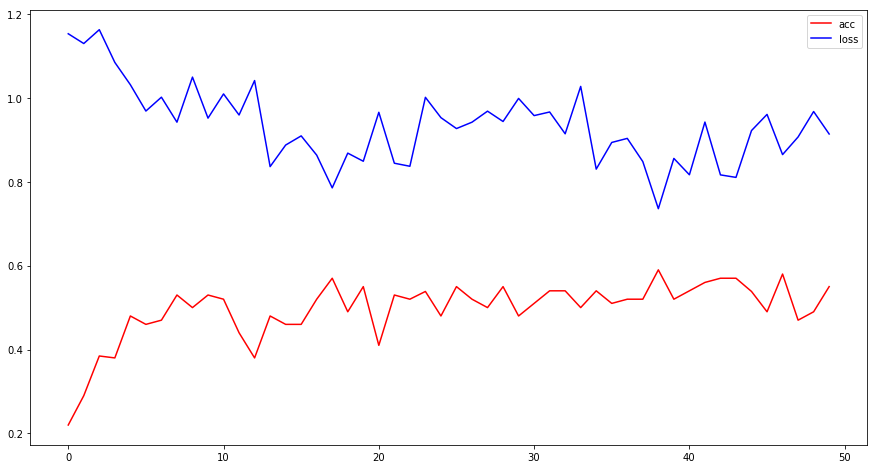

In [77]:
plt.figure(figsize = (15,8))
plt.plot(list_acc,'r',label = 'acc')
plt.plot(list_loss,'b',label = 'loss')
plt.legend()
plt.show()